In [ ]:
import pandas as pd # data analysis and manipulation tool
import numpy as np # Numerical computing tools
import seaborn as sns  # visualization library
import matplotlib.pyplot as plt  # another visualization library



In [ ]:
df = pd.read_csv('virus_hw5.csv', sep=',', header=0)

In [ ]:
# remove all the irrelevant fields 
relevant_features = ["DisciplineScore", "TimeOnSocialActivities", "AgeGroup", "StepsPerYear",
                     "pcrResult4", "pcrResult1", "pcrResult12", "pcrResult5", "pcrResult16",
                     "pcrResult14", "SyndromeClass"]

mean_discipline = 4.95
mean_social_activity_time = 5.32

results_fields = ['Disease', 'Spreader', 'atRisk']

## DISCIPLINE SCORE

In [ ]:
# DisciplineScoreHandler


# any value above 10 will be divided by 10

outlier_discipline_score = df.DisciplineScore > 10

df.loc[outlier_discipline_score, "DisciplineScore"] = df.loc[outlier_discipline_score, "DisciplineScore"] / 10

# fill others with mean
# replace the NA values with mean
df.DisciplineScore = df.DisciplineScore.fillna(mean_discipline)

## SOCIAL ACTIVITIES

In [ ]:
# SocialActivitiesHandler

no_social_activities_score_mask = df.TimeOnSocialActivities.isna()
invalid_activities_score_mask = df.TimeOnSocialActivities < 5

# check where it is not nan at AvgHouseholdExpenseOnPresents
no_expenses_expenses_mask = df.AvgHouseholdExpenseOnPresents.isna()

# merge 2 masks
social_activities_na_refill_series = no_social_activities_score_mask & ~no_expenses_expenses_mask
social_activities_invalid_refill_series = invalid_activities_score_mask & ~no_expenses_expenses_mask


df.loc[social_activities_na_refill_series, "TimeOnSocialActivities"] = df.loc[social_activities_na_refill_series, "AvgHouseholdExpenseOnPresents"] / 10
df.loc[social_activities_invalid_refill_series, "TimeOnSocialActivities"] = df.loc[social_activities_invalid_refill_series, "AvgHouseholdExpenseOnPresents"] / 10

# all the other missing data will receive the mean value, since no other dependency was found.

# replace the NA values with mean
# calculate new mean_social_activity_time
mean_social_activity_time = df.TimeOnSocialActivities.mean()

df.TimeOnSocialActivities = df.TimeOnSocialActivities.fillna(mean_social_activity_time)


## AGE HANDLER

In [ ]:
# Age Handler

# For StepsPerYear, find mean value for each age group
# For AvgMinSportsPerDay, find mean value for each age group
# Then is age is missing, but of [StepsPerYear, AvgMinSportsPerDay] exists, find closest and fill this age

no_age_idxs = df.AgeGroup.isna()

age_values = df.AgeGroup[~no_age_idxs].unique().astype("int")   # array([3, 2, 6, 4, 5, 7, 1, 8, 0])
age_values.sort()  # array([0, 1, 2, 3, 4, 5, 6, 7, 8])

mean_steps_vs_age = {}
mean_avg_sports_vs_age = {}

min_steps_vs_age = {}
min_avg_sports_vs_age = {}

max_steps_vs_age = {}
max_avg_sports_vs_age = {}

for age_value in age_values:
    mask = df.AgeGroup == age_value
    
    mean_avg_sports_vs_age[age_value] = (df.loc[mask].AvgMinSportsPerDay.mean())
    mean_steps_vs_age[age_value] = (df.loc[mask].StepsPerYear.mean())
    
    min_avg_sports_vs_age[age_value] = (df.loc[mask].AvgMinSportsPerDay.min())
    min_steps_vs_age[age_value] = (df.loc[mask].StepsPerYear.min())
    
    max_avg_sports_vs_age[age_value] = (df.loc[mask].AvgMinSportsPerDay.max())
    max_steps_vs_age[age_value] = (df.loc[mask].StepsPerYear.max())    
    

# for now fill with mean
df['AgeGroup'] = df.AgeGroup.fillna(np.mean(df.AgeGroup))
    

In [ ]:
# corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

## STEPS PER YEAR

In [ ]:
# StepsPerYear handler

# fill the missing StepsPerYear with AvgMinSportsPerDay
no_StepsPerYear_score_mask = df.StepsPerYear.isna()

# check where it is not nan at AvgMinSportsPerDay
AvgMinSportsPerDay_mask = df.AvgMinSportsPerDay.isna()

# merge 2 masks
StepsPerYear_na_refill_series = no_StepsPerYear_score_mask & ~AvgMinSportsPerDay_mask

delta = 1.75*(10**7) / 150 # from graph
df.loc[StepsPerYear_na_refill_series, "StepsPerYear"] = df.loc[StepsPerYear_na_refill_series, "AvgMinSportsPerDay"] * delta

# all the other missing data will receive the mean value, since no other dependency was found.

# replace the NA values with mean
mean_StepsPerYear = df.StepsPerYear.mean()

df['StepsPerYear'] = df.StepsPerYear.fillna(np.mean(df.StepsPerYear))

## PCR RESULTS

In [ ]:
# Dead with PCR results

from sklearn.impute import KNNImputer
from scipy import stats


impute_type = "mean"

df_pcr = df.copy()

pcr_results = [i+1 for i in range(16)]
pcr_fields = ["pcrResult" + str(i) for i in pcr_results]

# leave only PCR columns
for column in df_pcr.columns:
    if column not in pcr_fields and column != "PatientID":
        df_pcr = df_pcr.drop(columns = column)

# validation and test IDs start with offset
ID_offset = df_pcr.PatientID[0]

# for KNN : Replace outliers with mean, later do KNN imputation
# for MEAN : Replace outliers with mean for the current class

for key in pcr_fields:

    new_df = df_pcr[['PatientID', key]].copy()

    # remove nans
    new_df = new_df.dropna()

    IDs_list = list(new_df.PatientID)

    z = np.abs(stats.zscore(new_df[key]))
    outliers_arr = np.where(z > 2)

    if len(outliers_arr[0]) != 0:

        for outlier_idx in outliers_arr[0]:
            # dropping those rows from the new_df for mean calculation
            new_df = new_df.drop(IDs_list[outlier_idx] - ID_offset)

    else:
        pass  # no outliers were detected

    # find the mean WITHOUT the outliers
    new_mean = new_df[key].mean()

    # fill the outliers in the original df with mean / nan
    for outlier_idx in outliers_arr[0]:
        # dropping those rows from the new_df

        if impute_type == "knn":
            # later do the knn imputation on all
            df_pcr.at[IDs_list[outlier_idx] - ID_offset, key] = np.nan
        elif impute_type == "mean":
            # replace the outliers with mean
            df_pcr.at[IDs_list[outlier_idx] - ID_offset, key] = new_mean


if impute_type == "knn":
    # IMPUTER using KNN
    df_pcr = df_pcr.drop(['PatientID'], axis=1)
    imputer = KNNImputer(n_neighbors=3)  # k-nearest neighbors impute,

    df_mx = imputer.fit_transform(df_pcr)
    df_pcr = pd.DataFrame(df_mx, list(df["PatientID"]), pcr_fields)

elif impute_type == "mean":
    df_pcr = df_pcr.fillna(df.mean())

# replace the original pcr columns with new imputed columns
for column in df_pcr.columns:
    df[column] = df_pcr[column]








In [ ]:
# SyndromeClass handler

df.SyndromeClass = df.SyndromeClass.fillna(5)

In [ ]:
# get the results for the viruses to get the "Correct labels" for clustering


# test result classified by labels
li = df.TestResultsCode.tolist()
labels = [item.split('_') for item in li]
for item in labels:
    if len(item) == 4:
        add = item[0] + item[1]
        item = item.insert(0, add)
for item in labels:
    if 'not' in item:
        item.remove('not')
    if 'detected' in item:
        item.remove('detected')

disease = [la[0] for la in labels]
spread = [la[1] for la in labels]
risk = [la[2] for la in labels]

# mapping dict
# mapping = {}
# for i,x in enumerate(set(disease)):
#     mapping[x] = i

# to be sure we're consistent. is also used in automatic classificaion
disease_mapping = {'flue': 0, 'covid': 1, 'cmv': 2, 'cold': 3, 'measles': 4, 'notdetected': 5}

disease_indexed = [disease_mapping[disease_name] for disease_name in disease]


spread_encode = pd.Series(spread).str.get_dummies()
risk_encode = pd.Series(risk).str.get_dummies()

# disease_encode = pd.DataFrame(disease_encode)
disease_encode = pd.DataFrame({'Disease' : disease_indexed})
spread_encode = pd.DataFrame(spread_encode)
risk_encode = pd.DataFrame(risk_encode)


spread_encode = spread_encode.drop(['NotSpreader'], axis=1)
risk_encode = risk_encode.drop(['NotatRisk'], axis=1)

frames = [df, disease_encode, spread_encode, risk_encode]
df = pd.concat(frames, axis=1)

# drop the original label
df = df.drop(columns='TestResultsCode')

In [ ]:
features_to_stay = ["Disease"] + relevant_features

for column in df.columns:
    if column not in features_to_stay:
        df = df.drop(columns = column)

In [ ]:
df.head()

,AgeGroup,DisciplineScore,StepsPerYear,SyndromeClass,TimeOnSocialActivities,pcrResult1,pcrResult12,pcrResult14,pcrResult16,pcrResult4,pcrResult5,Disease
0,3.000000,5.00,1.693611e+07,2.0,71.096219,-0.783570,-1.728232,1.239142,0.561232,0.727264,0.007465,0
1,3.360444,8.00,1.298412e+07,3.0,59.209984,-0.288236,-10.181192,0.330100,1.805613,-0.355124,-0.347716,4
2,3.360444,4.95,8.560931e+06,1.0,27.962990,0.590215,0.905512,1.938797,0.743885,-1.234402,0.258255,5
3,3.000000,4.00,1.465361e+07,3.0,49.786640,-1.440436,-0.933486,45.244016,2.612904,0.366601,0.007465,1
4,2.000000,4.00,1.153898e+07,5.0,76.434326,-0.964806,-2.940880,3.368657,0.506867,1.546139,0.217398,1


In [ ]:
# use standard scaler

from sklearn.preprocessing import StandardScaler
import copy

df_scaled = copy.deepcopy(df)

sc = StandardScaler()


df_scaled = df_scaled.drop(columns="Disease")

df_scaled_np = sc.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled_np, index=df_scaled.index, columns=df_scaled.columns)

df_scaled["Disease"] = df["Disease"]



In [ ]:
df_scaled.head()

,AgeGroup,DisciplineScore,StepsPerYear,SyndromeClass,TimeOnSocialActivities,pcrResult1,pcrResult12,pcrResult14,pcrResult16,pcrResult4,pcrResult5,Disease
0,-0.316986,0.075141,8.538730e-01,-0.785360,1.062702,-1.001072,-0.227207,-0.411893,-1.468764,0.649749,0.003929,0
1,0.000000,2.271522,2.286332e-01,0.008022,0.276271,-0.475688,-2.413755,-0.444356,0.281801,-0.494200,-0.702037,4
2,0.000000,0.038534,-4.711525e-01,-1.578742,-1.791130,0.456054,0.454071,-0.386908,-1.211812,-1.423487,0.502404,5
3,-0.316986,-0.656986,4.927611e-01,0.008022,-0.347208,-1.697787,-0.021628,1.159557,1.417478,0.268573,0.003929,1
4,-1.196418,-0.656986,-3.536236e-15,1.594786,1.415888,-1.193302,-0.540885,-0.335846,-1.545244,1.515198,0.421195,1


# CLUSTERING

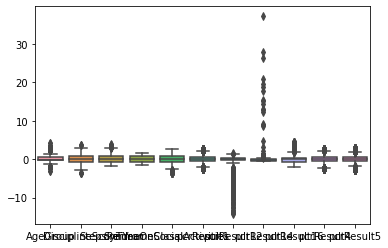

In [ ]:
ax = sns.boxplot(data=df_scaled.drop(columns="Disease"))

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import numpy as np

X = df_scaled.drop(['Disease'], axis=1).values


kmeans = KMeans(n_clusters=6, random_state=0).fit(X)


# clustering_virus = SpectralClustering(n_clusters=6,
#         affinity='nearest_neighbors',
#         assign_labels="discretize",
#         random_state=0).fit(X)

gm = GaussianMixture(n_components=6,  covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)

gm = gm.fit(X)


In [ ]:
from sklearn.decomposition import PCA

reduced_data_3d = PCA(n_components=3).fit_transform(X)

# labels_clustering = kmeans.labels_
# labels_clustering = clustering_virus.labels_
labels_clustering = gm.predict(X) #labels

# or using the real labels to see that data fits
labels_true = list(df_scaled["Disease"])



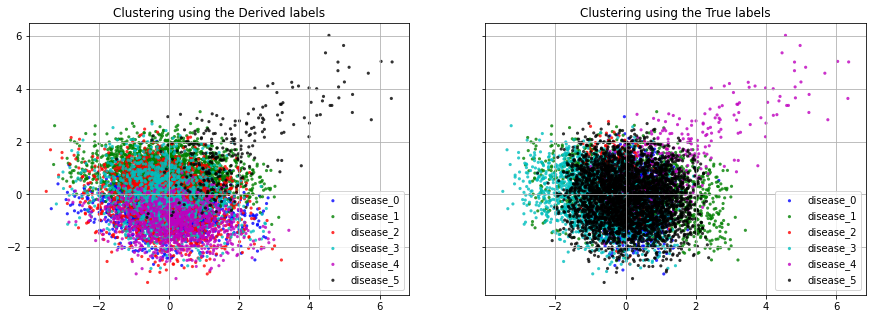

In [ ]:
colors = ('b', 'g', 'r', 'c', 'm', 'k')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
axes_to_use = [1,2]

for idx in range(6):
    color = colors[idx]
    
    class_idx_clustering = [index for index, val in enumerate(labels_clustering) if val == idx]

    x_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[0]]
    y_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[1]]   

    ax1.scatter(x_clustering, y_clustering, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')
    
    class_idx_true = [index for index, val in enumerate(labels_true) if val == idx]

    x_true = reduced_data_3d[class_idx_true,axes_to_use[0]]
    y_true = reduced_data_3d[class_idx_true,axes_to_use[1]]    
    
    
    ax2.scatter(x_true, y_true, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')


ax1.legend()
ax1.grid(True)
ax1.set_title("Clustering using the Derived labels")

ax2.legend()
ax2.grid(True)
ax2.set_title("Clustering using the True labels")

plt.show()

# CLASSIFICATION

In [ ]:
# using the adaboost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_true, test_size=0.2, random_state=42)

# n_estimators = 500, estimator = DecisionTreeClassifier(max_depth=3) - gives 0.7 error on test

clf = AdaBoostClassifier(n_estimators=700, 
                         learning_rate=0.07,
                         random_state=0,
                         algorithm = 'SAMME',
                         base_estimator = DecisionTreeClassifier(max_depth=4))
clf.fit(X_train, y_train)


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [ ]:
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

print(f"Train score : {score_train}")
print(f"Test score : {score_test}")

Train score : 0.8431944444444445
Test score : 0.82


In [ ]:
# SOME HISTORY

# clf = AdaBoostClassifier(n_estimators=500, 
#                          learning_rate=0.1,
#                          random_state=0,
#                          algorithm = 'SAMME',
#                          base_estimator = DecisionTreeClassifier(max_depth=4))

# Train score : 0.8444444444444444
# Test score : 0.815
    
# clf = AdaBoostClassifier(n_estimators=700, 
#                          learning_rate=0.1,
#                          random_state=0,
#                          algorithm = 'SAMME',
#                          base_estimator = DecisionTreeClassifier(max_depth=4)) 

# Train score : 0.8447222222222223
# Test score : 0.8183333333333334
    
# clf = AdaBoostClassifier(n_estimators=700, 
#                          learning_rate=0.07,
#                          random_state=0,
#                          algorithm = 'SAMME',
#                          base_estimator = DecisionTreeClassifier(max_depth=4))   

# Train score : 0.8431944444444445
# Test score : 0.82

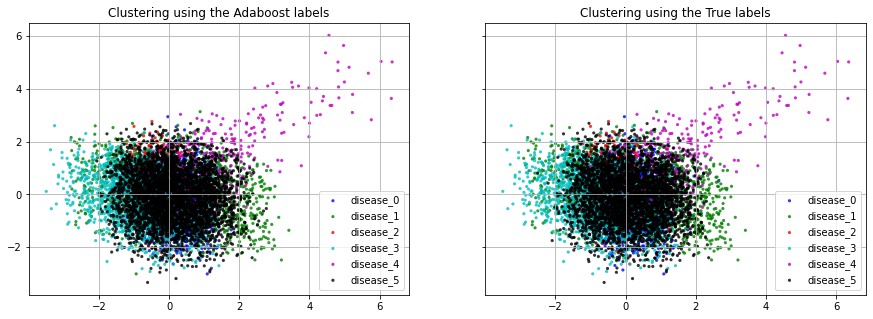

In [ ]:
# Vizualizing the true labels and  predicted labels from the adaboost

labels_adaboost = clf.predict(X)

colors = ('b', 'g', 'r', 'c', 'm', 'k')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
axes_to_use = [1,2]

for idx in range(6):
    color = colors[idx]
    
    class_idx_clustering = [index for index, val in enumerate(labels_adaboost) if val == idx]

    x_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[0]]
    y_clustering = reduced_data_3d[class_idx_clustering,axes_to_use[1]]   

    ax1.scatter(x_clustering, y_clustering, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')
    
    class_idx_true = [index for index, val in enumerate(labels_true) if val == idx]

    x_true = reduced_data_3d[class_idx_true,axes_to_use[0]]
    y_true = reduced_data_3d[class_idx_true,axes_to_use[1]]    
    
    
    ax2.scatter(x_true, y_true, c=color, s=10, label=f"disease_{idx}",
               alpha=0.8, edgecolors='none')


ax1.legend()
ax1.grid(True)
ax1.set_title("Clustering using the Adaboost labels")

ax2.legend()
ax2.grid(True)
ax2.set_title("Clustering using the True labels")

plt.show()

In [ ]:
for indx, (label_t, label_a) in enumerate(zip(labels_true, labels_adaboost)):
    print(f"{label_t} <-> {label_a} : {label_t == label_a}")
    if indx > 20:
        break
        
l_t_np = np.array(labels_true)
l_a_np = np.array(labels_adaboost)
true_labels = sum(l_t_np == l_a_np)

print(f"True: {true_labels} / {len(labels_true)}")

0 <-> 5 : False
4 <-> 4 : True
5 <-> 3 : False
1 <-> 1 : True
1 <-> 1 : True
0 <-> 0 : True
1 <-> 5 : False
5 <-> 0 : False
5 <-> 5 : True
3 <-> 3 : True
3 <-> 3 : True
4 <-> 4 : True
4 <-> 4 : True
1 <-> 1 : True
1 <-> 1 : True
0 <-> 0 : True
3 <-> 5 : False
5 <-> 5 : True
0 <-> 5 : False
3 <-> 3 : True
2 <-> 5 : False
1 <-> 0 : False
True: 7547 / 9000


#Class Imbalance

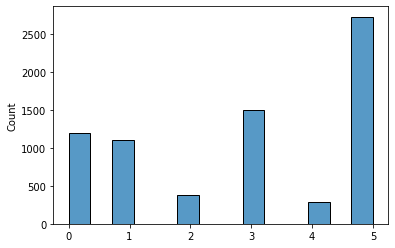

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels_true, test_size=0.2, random_state=42)
sns.histplot(data=y_train)



[SMOTENC documenation](https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC)

In [ ]:

from imblearn.over_sampling import SMOTENC
from collections import Counter



sm = SMOTENC(random_state=42, categorical_features=[0, 1,2,3],sampling_strategy='all' )

X_res, y_res = sm.fit_resample(X, labels_true)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 3455, 4: 3455, 5: 3455, 1: 3455, 3: 3455, 2: 3455})


[SMOTEENN](https://imbalanced-learn.org/stable/generated/imblearn.combine.SMOTEENN.html#imblearn.combine.SMOTEENN)

In [ ]:
from imblearn.combine import SMOTETomek 
from collections import Counter


sm = SMOTETomek(random_state=42)

X_res, y_res = sm.fit_resample(X, labels_true)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({4: 3455, 2: 3452, 1: 3422, 3: 3401, 0: 3398, 5: 3322})


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_res)


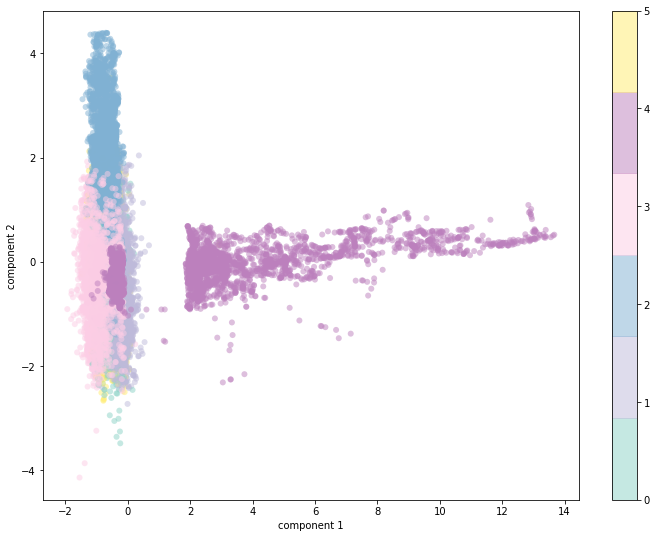

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition

np.random.seed(5)

fig = plt.figure(1, figsize=(12, 9))

y = y_res #labels

pca = decomposition.PCA(n_components=2)
X_2 = pca.fit_transform(X_res)
plt.scatter(X_2[:, 0], X_2[:, 1],
            c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Set3', 6))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

#AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=1000,
    learning_rate=.09)
bdt.fit(X_res_train, y_res_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
bdt.score(X_test,y_test)

0.7816666666666666

#MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, hidden_layer_sizes=(25),max_iter=5000).fit(X_res_train, y_res_train)

clf.fit(X_res_train, y_res_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=25, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=5000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
clf.score( X_test, y_test )

0.7666666666666667

#Ensemble

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=1000,
    learning_rate=.09)
clf2 = MLPClassifier(random_state=1, hidden_layer_sizes=(25),max_iter=5000).fit(X_res_train, y_res_train)
clf3 = GaussianNB()

eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_res_train, y_res_train)


eclf2 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft')
eclf2 = eclf2.fit(X_res_train, y_res_train)

eclf3 = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
       voting='soft', weights=[2,1,1],
       flatten_transform=True)
eclf3 = eclf3.fit(X_res_train, y_res_train)


#Model Evaluation
## Classification task involves unbalanced data, therefore accuracy is not indicative of model performance. 
ROC score is optimal
Recall is second-most optimal

[ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [ ]:
from sklearn.metrics import roc_auc_score


#Binary Classification
## NO/YES virus

In [ ]:
print('Resampled dataset shape %s' % Counter(labels_true))

Resampled dataset shape Counter({5: 3455, 3: 1849, 0: 1486, 1: 1388, 2: 467, 4: 355})


In [ ]:
labels_bin = [ 0 if label<5 else 1 for label in labels_true ]
print('Resampled dataset shape %s' % Counter(labels_bin))

Resampled dataset shape Counter({0: 5545, 1: 3455})


In [ ]:
X_bin, y_bin = X, labels_bin #binary dataset


In [ ]:
from imblearn.combine import SMOTETomek 
from collections import Counter
from sklearn.model_selection import train_test_split


sm = SMOTETomek(random_state=42)

X_bin_res, y_bin_res = sm.fit_resample(X, labels_bin) #up-sample
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin_res, y_bin_res, test_size=0.2, random_state=42) #train test split


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Resampled dataset shape %s' % Counter(y_bin_res))

Resampled dataset shape Counter({0: 5265, 1: 5265})


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=1000,
    learning_rate=.09)
bdt.fit(X_bin_train, y_bin_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
y_true, y_pred = y_bin_test, bdt.predict(X_bin_test)

##**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['0','1']))


              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1054
           1       0.89      0.91      0.90      1052

    accuracy                           0.90      2106
   macro avg       0.90      0.90      0.90      2106
weighted avg       0.90      0.90      0.90      2106



In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, bdt.predict_proba(X_bin_test)[:, 1])

0.9625156023405314

### NN Binary Classification

In [ ]:
nn = MLPClassifier(random_state=1, hidden_layer_sizes=(25, 10),max_iter=5000).fit(X_res_train, y_res_train)
y_true, y_pred = y_bin_test, nn.predict(X_bin_test)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['0','1']))

IndexError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, bdt.predict_proba(X_bin_test)[:, 1])

In [ ]:
np.array(X_bin_test)

array([[-3.16985993e-01, -1.38911339e+00,  3.31824939e+00, ...,
         2.81800561e-01,  3.74779416e-01, -1.78949045e+00],
       [ 0.00000000e+00,  3.85342852e-02, -1.96660418e-01, ...,
        -1.23936209e+00, -1.64186994e-02,  3.92879060e-03],
       [-1.19641768e+00,  8.07267651e-01, -1.04847275e+00, ...,
         1.05583545e-02, -1.67293885e+00, -3.82390647e-01],
       ...,
       [-3.16985993e-01,  1.53939467e+00, -1.02764600e+00, ...,
         4.33388695e-01, -1.00334812e+00, -9.92450235e-04],
       [-2.05826082e-01,  1.28265407e+00, -3.84452106e-01, ...,
         4.45589991e-01, -1.06794796e+00, -9.92450235e-04],
       [ 0.00000000e+00,  1.53939467e+00,  2.27603159e+00, ...,
         5.13871174e-01,  4.21068697e-03,  3.92879060e-03]])

## Ensemble for Binary Classification

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=1000,
    learning_rate=.09)
clf2 = MLPClassifier(random_state=1, hidden_layer_sizes=(25),max_iter=5000)
clf3 = GaussianNB()

eclf1 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_bin_train, y_bin_train)


eclf2 = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
        voting='soft')
eclf2 = eclf2.fit(X_bin_train, y_bin_train)

eclf3 = VotingClassifier(estimators=[
       ('lr', clf1), ('rf', clf2), ('gnb', clf3)],
       voting='soft', weights=[2,1,1],
       flatten_transform=True)
eclf3 = eclf3.fit(X_bin_train, y_bin_train)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_bin_test, eclf1.predict(X_bin_test), target_names=['0','1']))

ValueError: ignored

array([0, 0, 0, ..., 1, 1, 0])

#Transfer Learning

In [409]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [410]:
model = keras.Sequential(
    [
    layers.Dense(11, activation="relu", name="layer_1",input_shape=(11,)),
    layers.Dense(150, activation="relu", name="layer_2"),
    layers.Dense(100, activation="relu", name="layer_3"),
    layers.Dense(100, activation="relu", name="layer_4"),
    layers.Dense(100, activation="relu", name="layer_5"),
    layers.Dense(50, activation="relu", name="layer_6"),
    layers.Dense(1, name="layer_7")
    ]
)



Its layers are accessible via the `layers` attribute:

In [411]:
model.layers

In [412]:
#model.weights

In [413]:
print("Number of weights after calling the model:", len(model.weights))  # 6

Number of weights after calling the model: 14


In [414]:
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 11)                132       
_________________________________________________________________
layer_2 (Dense)              (None, 150)               1800      
_________________________________________________________________
layer_3 (Dense)              (None, 100)               15100     
_________________________________________________________________
layer_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
layer_7 (Dense)              (None, 1)               

###Save Model

In [415]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')

###Transfer Learning Workflow

The most common incarnation of transfer learning in the context of deep learning is the following worfklow:


1.   Take layers from a previously trained model.
2.   Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4.Train the new layers on your dataset.

A last, optional step, is fine-tuning, which consists of unfreezing the entire model you obtained above (or part of it), and re-training it on the new data with a very low learning rate. This can potentially achieve meaningful improvements, by incrementally adapting the pretrained features to the new data.



In [416]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [417]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(), recall_m],
)

epochs = 200
model.fit(x=np.array(X_bin_train),y=np.array(y_bin_train), epochs=epochs, validation_data=(np.array(X_bin_test), np.array(y_bin_test)))


Epoch 1/200
264/264 [==============================] - 2s 4ms/step - loss: 0.6703 - binary_accuracy: 0.5137 - recall_m: 0.0676 - val_loss: 0.6292 - val_binary_accuracy: 0.5783 - val_recall_m: 0.2366
Epoch 2/200
264/264 [==============================] - 1s 3ms/step - loss: 0.6228 - binary_accuracy: 0.5943 - recall_m: 0.2837 - val_loss: 0.5987 - val_binary_accuracy: 0.6187 - val_recall_m: 0.3421
Epoch 3/200
264/264 [==============================] - 1s 3ms/step - loss: 0.5939 - binary_accuracy: 0.6174 - recall_m: 0.3199 - val_loss: 0.5846 - val_binary_accuracy: 0.6111 - val_recall_m: 0.2608
Epoch 4/200
264/264 [==============================] - 1s 3ms/step - loss: 0.5642 - binary_accuracy: 0.6250 - recall_m: 0.3064 - val_loss: 0.5664 - val_binary_accuracy: 0.6429 - val_recall_m: 0.3764
Epoch 5/200
264/264 [==============================] - 1s 3ms/step - loss: 0.5558 - binary_accuracy: 0.6498 - recall_m: 0.4346 - val_loss: 0.5511 - val_binary_accuracy: 0.6719 - val_recall_m: 0.4679
Epoch

In [418]:
#save weights for later re-use
model.save_weights('my_weights.h5', overwrite=True)


In [419]:
#define model that fits weights
model = keras.Sequential(
    [
    layers.Dense(11, activation="relu", name="layer_1",input_shape=(11,)),
    layers.Dense(150, activation="relu", name="layer_2"),
    layers.Dense(100, activation="relu", name="layer_3"),
    layers.Dense(100, activation="relu", name="layer_4"),
    layers.Dense(100, activation="relu", name="layer_5"),
    layers.Dense(50, activation="relu", name="layer_6"),
    layers.Dense(1, name="layer_7")
    ]
)



# Presumably you would want to first load pre-trained weights.
model.load_weights('my_weights.h5')



In [420]:
#copy to another model
t_model = keras.Sequential()
for layer in model.layers[:-4]: # exclude some last layers
  t_model.add(layer)
for layer in t_model.layers:
  layer.trainable = False
t_model.add(layers.Dense(100, activation="relu", name="layer_8"))
t_model.add(layers.Dense(100, activation="relu", name="layer_20"))
t_model.add(layers.Dense(10, activation="relu", name="layer_9"))
t_model.add(layers.Dense(6, activation='softmax',name="layer_10"))


In [421]:
t_model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 11)                132       
_________________________________________________________________
layer_2 (Dense)              (None, 150)               1800      
_________________________________________________________________
layer_3 (Dense)              (None, 100)               15100     
_________________________________________________________________
layer_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
layer_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
layer_9 (Dense)              (None, 10)                1010      
_________________________________________________________________
layer_10 (Dense)             (None, 6)               

In [422]:
from sklearn.preprocessing import OneHotEncoder #one-hot encode 
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array(y_res_train).reshape(-1,1))
y_train_enc = enc.transform(np.array(y_res_train).reshape(-1,1)).toarray()
y_test_enc = enc.transform(np.array(y_test).reshape(-1,1)).toarray()

In [423]:
# Recompile and train (this will only update the weights of non-first layers.
t_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy(), recall_m],
)

epochs = 250
history2 = t_model.fit(x=np.array(X_res_train),y=np.array(y_train_enc), epochs=epochs, validation_data=(np.array(X_test), np.array(y_test_enc)))


Epoch 1/250
512/512 [==============================] - 2s 2ms/step - loss: 1.0959 - categorical_accuracy: 0.5688 - recall_m: 0.3710 - val_loss: 0.9337 - val_categorical_accuracy: 0.6350 - val_recall_m: 0.4879
Epoch 2/250
512/512 [==============================] - 1s 2ms/step - loss: 0.7687 - categorical_accuracy: 0.7135 - recall_m: 0.5838 - val_loss: 0.8981 - val_categorical_accuracy: 0.6528 - val_recall_m: 0.5203
Epoch 3/250
512/512 [==============================] - 1s 2ms/step - loss: 0.7270 - categorical_accuracy: 0.7226 - recall_m: 0.6006 - val_loss: 0.8510 - val_categorical_accuracy: 0.6667 - val_recall_m: 0.5636
Epoch 4/250
512/512 [==============================] - 1s 2ms/step - loss: 0.6887 - categorical_accuracy: 0.7437 - recall_m: 0.6317 - val_loss: 0.8321 - val_categorical_accuracy: 0.6678 - val_recall_m: 0.5609
Epoch 5/250
512/512 [==============================] - 1s 2ms/step - loss: 0.6680 - categorical_accuracy: 0.7451 - recall_m: 0.6449 - val_loss: 0.8109 - val_categor

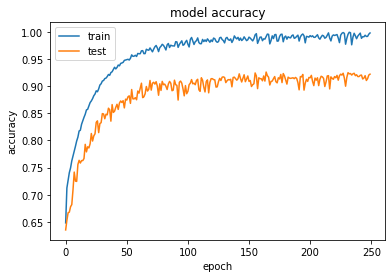

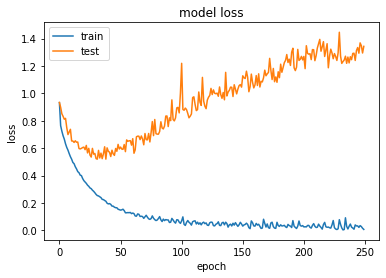

In [424]:
  # summarize history for accuracy
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()